In [342]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
#try:
#    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
#except FileNotFoundError:
#    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#import pacmap
import umap
#import trimap

#from scipy.stats import chisquare, chi2_contingency, pearsonr
#from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
#from scipy.spatial import distance
#import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.decomposition import PCA
#from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness
from sklearn.cluster import KMeans, OPTICS, affinity_propagation, AgglomerativeClustering
# add GMM
from sklearn.mixture import GaussianMixture as GMM, BayesianGaussianMixture as BGMM, VBGMM

import skfuzzy as fuzz


#from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
#from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
#from sklearn.neighbors import KNeighborsClassifier as KNN
#from sklearn.cluster import KMeans

from hembedder.utils.distance import poincarre_dist, hyperboloid_dist, fractional_distance, Distance
#from hembedder.utils.quality_metrics import CDEmbeddingPerformance
#import numpy.linalg as la
#import torch 

#from numba import njit

#import faiss
import gc

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.stats import entropy

from tqdm import tqdm

from pysr import PySRRegressor
from gplearn.genetic import SymbolicTransformer
from sklego.meta import ZeroInflatedRegressor
#from lineartree import LinearTreeRegressor, LinearForestRegressor

from xgboost import XGBRegressor, XGBRFClassifier

from typing import List, Tuple, Iterable, Callable

import random


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# a function to run a clustering algorithm in a bootstrapping fashion
# the outcome is a list of clustering models
def clustering_bootstrapping(data: pd.DataFrame, 
                             n_clusters: int=10,
                             n_bootstraps: int=100, 
                             sample_size: int=50000,
                             clusterer: str='kmeans',
                             **kwargs)-> List[Callable]:
    if kwargs.get('n_init', None) is None:
        n_init = 10
    else:
        n_init = kwargs.get('n_init')
    
    model_list = []
    for i in tqdm(range(n_bootstraps)):
        # sample data
        sample = data.sample(sample_size, replace=True)
        # cluster sample
        if clusterer == 'kmeans':
            if i==0:
                model = KMeans(n_clusters=n_clusters, random_state=123, n_init=n_init)
                model.fit(sample)
                init_means = model.cluster_centers_
            else:
                model = KMeans(n_clusters=n_clusters, random_state=123, init=init_means, n_init=n_init)
                model.fit(sample)
        elif clusterer == 'optics':
            model = OPTICS(min_samples=100, n_jobs=-1)
            model.fit(sample)
        elif clusterer == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_clusters)
            model.fit(sample)
        elif clusterer == 'gmm':
            if i==0:
                model = GMM(n_components=n_clusters, random_state=123)
                model.fit(sample)
                init_means = model.means_
            else:
                model = GMM(n_components=n_clusters, random_state=123, means_init=init_means)
                model.fit(sample)
        elif clusterer == 'bgmm':
            if i==0:
                model = BGMM(n_components=n_clusters, random_state=123)
                model.fit(sample)
                init_means = model.mean_prior_
            else:
                model = BGMM(n_components=n_clusters, random_state=123, mean_prior=init_means)
                model.fit(sample)
        else:
            raise ValueError("Unknown clustering algorithm")
        model_list.append(model)
    return model_list
    
def assign_clusters(data: pd.DataFrame, 
                    model_list: List[Callable], 
                    clusterer='kmeans') -> pd.DataFrame:
    
    # get cluster labels
    if clusterer in ['kmeans']:
        labels = np.array([model.predict(data) for model in model_list])
        # get cluster centers
        centers = np.array([model.cluster_centers_ for model in model_list])
        # get cluster sizes
        sizes = np.array([np.bincount(label, minlength=centers.shape[1]) for label in labels])
    elif clusterer in ['gmm']:
        labels = np.array([model.predict(data) for model in model_list])
        # get cluster centers
        centers = np.array([model.means_ for model in model_list])
        # get cluster sizes
        sizes = np.array([np.bincount(label, minlength=centers.shape[1]) for label in labels])        
    return labels, centers, sizes 


def distance(v1, v2, metric='euclidean'):
    ''' Calculate the distance between two vectors '''
    if metric=='euclidean':
        return np.linalg.norm(v1 - v2)
    elif metric=='cosine':
        return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    elif metric=='poincarre':
        return poincarre_dist(v1, v2)
    elif metric=='manhattan':
        return np.linalg.norm(v1 - v2, ord=1)

In [4]:
#celldyn_full = pd.read_feather("L:\laupodteam\AIOS\Bram\data\CellDyn\\artifacts\celldyn_FULL_transformed_miceforest100_df.feather")
celldyn_full = pd.read_feather("/media/UMCU/data/CellDyn/artifacts/celldyn_FULL_transformed_miceforest100_df.feather")

meas_columns = [c for c in celldyn_full.columns if ('c_b' in c) | ("COMBO" in c)]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]
celldyn_full.drop(['index'], axis=1, inplace=True)

celldyn_full = celldyn_full.assign(gender=celldyn_full.gender.map({'M':0, 'F':1}))
celldyn_full.dropna(subset=['gender','draw_hour'], axis=0, inplace=True)
celldyn_full.rename(columns={'studyid_alle_celldyn':'study_id', 'afname_dt': 'sample_dt'}, inplace=True)
celldyn_full.set_index(['study_id', 'sample_dt'], inplace=True)

In [5]:
celldyn_emb = pd.read_feather("/media/UMCU/data/CellDyn/artifacts/umap_euclidean_euclidean_spectral_dims_6_n_n_50_n_epochs_400_densmap_True_embedded_data.feather")
celldyn_emb = celldyn_emb.assign(sex=celldyn_emb.sex.map({'M':0, 'F':1}))
celldyn_emb.dropna(subset=['sex','draw_hour'], axis=0, inplace=True)
celldyn_emb.set_index(['study_id', 'sample_dt'], inplace=True)

celldyn_emb = celldyn_emb.loc[celldyn_full.index]

## Bootstrapped Clustering

In [397]:
# a function to run a clustering algorithm in a bootstrapping fashion
# the outcome is a list of clustering models
def clustering_bootstrapping(data: pd.DataFrame, 
                             n_clusters: int=10,
                             n_bootstraps: int=100, 
                             sample_size: int=50000,
                             clusterer: str='kmeans',
                             align: bool=False,
                             **kwargs)-> List[Callable]:
    if kwargs.get('n_init', None) is None:
        n_init = 10
    else:
        n_init = kwargs.get('n_init')
    
    model_list = []
    for i in tqdm(range(n_bootstraps)):
        # sample data
        sample = data.sample(sample_size, replace=True)
        # cluster sample
        if clusterer == 'kmeans':
            if (i==0) | (align==False):
                model = KMeans(n_clusters=n_clusters, random_state=123, n_init=n_init)
                model.fit(sample)
                init_means = model.cluster_centers_
            else:
                model = KMeans(n_clusters=n_clusters, random_state=123, init=init_means, n_init=n_init)
                model.fit(sample)
        elif clusterer == 'optics':
            model = OPTICS(min_samples=100, n_jobs=-1)
            model.fit(sample)
        elif clusterer == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_clusters)
            model.fit(sample)
        elif clusterer == 'gmm':
            if (i==0) | (align==False):
                model = GMM(n_components=n_clusters, random_state=123)
                model.fit(sample)
                init_means = model.means_
            else:
                model = GMM(n_components=n_clusters, random_state=123, means_init=init_means)
                model.fit(sample)
        elif clusterer == 'bgmm':
            if (i==0) | (align==False):
                model = BGMM(n_components=n_clusters, random_state=123, max_iter=500)
                model.fit(sample)
                init_means = model.mean_prior_
            else:
                model = BGMM(n_components=n_clusters, random_state=123, mean_prior=init_means, max_iter=500)
                model.fit(sample)
        else:
            raise ValueError("Unknown clustering algorithm")
        model_list.append(model)
    return model_list
    
def assign_clusters(data: pd.DataFrame, 
                    model_list: List[Callable], 
                    clusterer='kmeans') -> pd.DataFrame:
    
    # get cluster labels
    if clusterer in ['kmeans']:
        labels = np.array([model.predict(data) for model in model_list])
        # get cluster centers
        centers = np.array([model.cluster_centers_ for model in model_list])
        # get cluster sizes
        sizes = np.array([np.bincount(label, minlength=centers.shape[1]) for label in labels])
    elif clusterer in ['gmm', 'bgmm']:
        labels = np.array([model.predict(data) for model in model_list])
        # get cluster centers
        centers = np.array([model.means_ for model in model_list])
        # get cluster sizes
        sizes = np.array([np.bincount(label, minlength=centers.shape[1]) for label in labels])        
    return labels, centers, sizes 


def distance(v1, v2, metric='euclidean'):
    ''' Calculate the distance between two vectors '''
    if metric=='euclidean':
        return np.linalg.norm(v1 - v2)
    elif metric=='cosine':
        return 1 - np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    elif metric=='poincarre':
        return poincarre_dist(v1, v2)
    elif metric=='manhattan':
        return np.linalg.norm(v1 - v2, ord=1)

In [479]:
gc.collect()
bclusters = clustering_bootstrapping(celldyn_full[meas_columns], n_clusters=10, n_bootstraps=60, sample_size=10000, clusterer='kmeans', n_init=1, align=True)
gc.collect()

100%|██████████| 60/60 [00:05<00:00, 10.55it/s]


0

In [480]:
test_set = celldyn_full.sample(10000, replace=True)[meas_columns]
labels, centers, sizes = assign_clusters(test_set, bclusters, clusterer='kmeans')

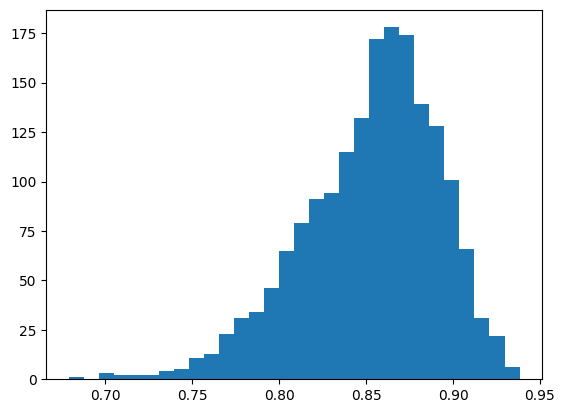

In [481]:
from sklearn.metrics.cluster import fowlkes_mallows_score, homogeneity_score, homogeneity_completeness_v_measure
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score, pair_confusion_matrix

cluster_overlap_list = []
for i in range(labels.shape[0]):
    for j in range(i+1, labels.shape[0]):
        cluster_overlap_list.append(fowlkes_mallows_score(labels[i], labels[j]))

plt.hist(cluster_overlap_list, bins=30);

In [482]:
# we want to re-order the cluster labels for each model such that the ordinal similarity between the models is maximized
init_sim = np.sum(np.corrcoef(labels))/labels.shape[0]**2
print(f"Initial similarity: {init_sim}")

#  we want to align the cluster id's based on the cluster centers or the cluster assignmnents
def align_cluster_assignments(labels: np.ndarray, centers: np.ndarray, method: str='centerwise', base_sel: int=0)-> np.ndarray:
    '''
        Centerwise, given, 1..N models, we align the 2,N models based on the cluster centers of model 1.
        I.e. we find the cluster center in model 2 that is closest to the cluster center in model 1 and assign the cluster id's accordingly
    '''
    if method == 'centerwise':
        base_centers = centers[base_sel]
        # find the closest cluster center for each model
        closest_centers = [[np.argmin([distance(bv.ravel(), _cv.ravel(), metric='cosine') 
                                            for _cv in cv]) 
                                                for bv in base_centers] 
                                                    for cv in centers[1:]
                                                    ]
        # now we have the closest cluster centers for each model, we can re-order the labels
        aligned_labels = [np.array([closest_centers[i][l] for l in labels[base_sel]]) for i in range(len(closest_centers))]
        aligned_centers = [centers[i][closest_centers[i]] for i in range(len(closest_centers))]

    '''
        TODO:
    	We want to re-order the cluster labels for each model such that the ordinal similarity between the models is maximized.
        We express this similarity with MCC (Matthews correlation coefficient)
    '''
    # first order the labels from the first model, use the order index
    # to order the labels of the other models

    # now change the labels of the other models to match the order of the first model


    return np.vstack(aligned_labels), np.stack(aligned_centers), closest_centers

aligned_labels, aligned_centers, closest_centers = align_cluster_assignments(labels, centers, method='centerwise', base_sel=0)
print(f"Aligned result: {np.sum(np.corrcoef(aligned_labels))/aligned_labels.shape[0]**2}")

Initial similarity: 0.8620458087735464
Aligned result: 0.9999999999999999


In [483]:
cluster_assignment = pd.DataFrame(aligned_labels.T, columns=['cluster_assignment_'+str(i) for i in range(aligned_labels.shape[0])])
cluster_assignment.index = test_set.index
cluster_assignment = cluster_assignment.assign(cluster_entropy=cluster_assignment.apply(lambda x: entropy(np.histogram(x, bins=10, density=True)[0]), axis=1))
cluster_assignment = cluster_assignment.assign(median_cluster=cluster_assignment.apply(lambda x: int(np.median(x)), axis=1))

<AxesSubplot: xlabel='dim_2', ylabel='dim_3'>

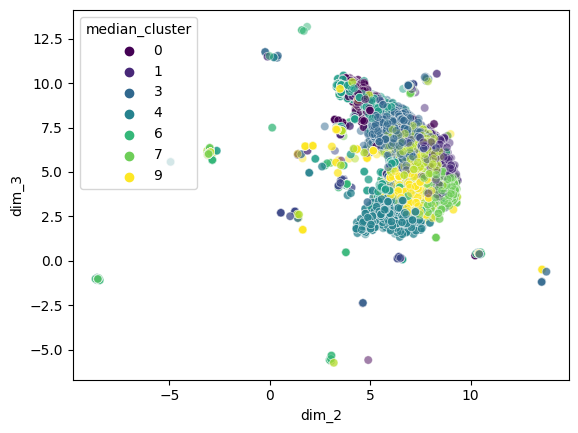

In [484]:
plot_df = celldyn_emb.loc[cluster_assignment.index].join(cluster_assignment[['cluster_entropy', 'median_cluster']], how='inner')
sns.scatterplot(data=plot_df, x='dim_2', y='dim_3', hue='median_cluster', palette='viridis', alpha=0.5, legend=True)

Text(0.5, 1.0, 'Cluster-center spread for cluster 0')

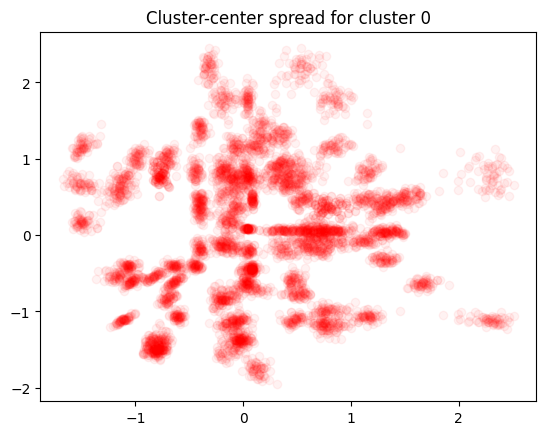

In [485]:
cluster_num = 0
for plot_count in range(100):
    _v1, _v2 = random.sample(range(0, aligned_centers.shape[2]), 2)
    if _v1 != _v2:
        v1 = aligned_centers[:, cluster_num, _v1]
        v2 = aligned_centers[:, cluster_num, _v2]
        plt.scatter(v1, v2, c='r', alpha=0.05)
plt.title(f"Cluster-center spread for cluster {cluster_num}")

## Fuzzy c-means

In [508]:
fpcs = []

df =celldyn_full[meas_columns] # ['age',  'gender']]
#df = celldyn_emb[['dim_1', 'dim_2', 'dim_3', 'dim_4',  'dim_5', 'dim_6']]
n_bootstrap = 30
sample_count = 25000
for n in tqdm(range(n_bootstrap)):
    data = df.sample(sample_count)
    _idx = data.index
    
    _fpcs = []
    for ncenters, ax in enumerate(range(10),2):
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T.values, c=ncenters, m=1.1, error=0.005, maxiter=1000, init=None, seed=123)

        # Store fpc values for later
        _fpcs.append(fpc)
    fpcs.append(_fpcs)

for i in range(n_bootstrap):
    plt.plot(np.arange(2, 12), fpcs[i], alpha=0.1, c='b')

plt.xlabel("Number of centers")
plt.ylabel("Fuzzy partition coefficient")

  0%|          | 0/30 [00:00<?, ?it/s]

## GMM evaluation

* use ```model.aic``` and ```model.bic``` to evaluate GMM
* use ```model.score_samples``` to evaluate BGMM

In [499]:
# get sample data
res_list = []
n_bootstrap = 20
sample_count = 10000
n_clusters = 30

df =celldyn_full[meas_columns+['age',  'gender']] 
#df = celldyn_emb[['dim_1', 'dim_2', 'dim_3', 'dim_4',  'dim_5', 'dim_6', 'age', 'sex']]
for b in tqdm(range(n_bootstrap)):
    data = df.sample(sample_count)
    # extract the cluster centers and aic, bic using GMM for 1..10 clusters
    
    for n in range(2, n_clusters+1):
        gmm = GMM(n_components=n, covariance_type='full', random_state=123).fit(data)
        #labels = gmm.predict(data)
        #centers = gmm.means_
        aic = gmm.aic(data)
        bic = gmm.bic(data)
        res_list.append({'bootstrap_round': b, 
                         'num_cluster': n, 
                         'AIC': np.log10(-aic), 
                         'BIC': np.log10(-bic)})
res_df = pd.DataFrame(res_list)

 20%|██        | 4/20 [22:50<1:30:36, 339.80s/it]/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/base/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/base/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
 95%|█████████▌| 19/20 [25:16:33<7:08:51, 25731.90s/it]/media/koekiemonster/home/bramiozo/.pyenv/versions/3.10.4/envs/base/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
100%|██████████| 20/20 [25:22:07<00:00

Text(0.5, 0.98, 'BIC and AIC for GMM clustering')

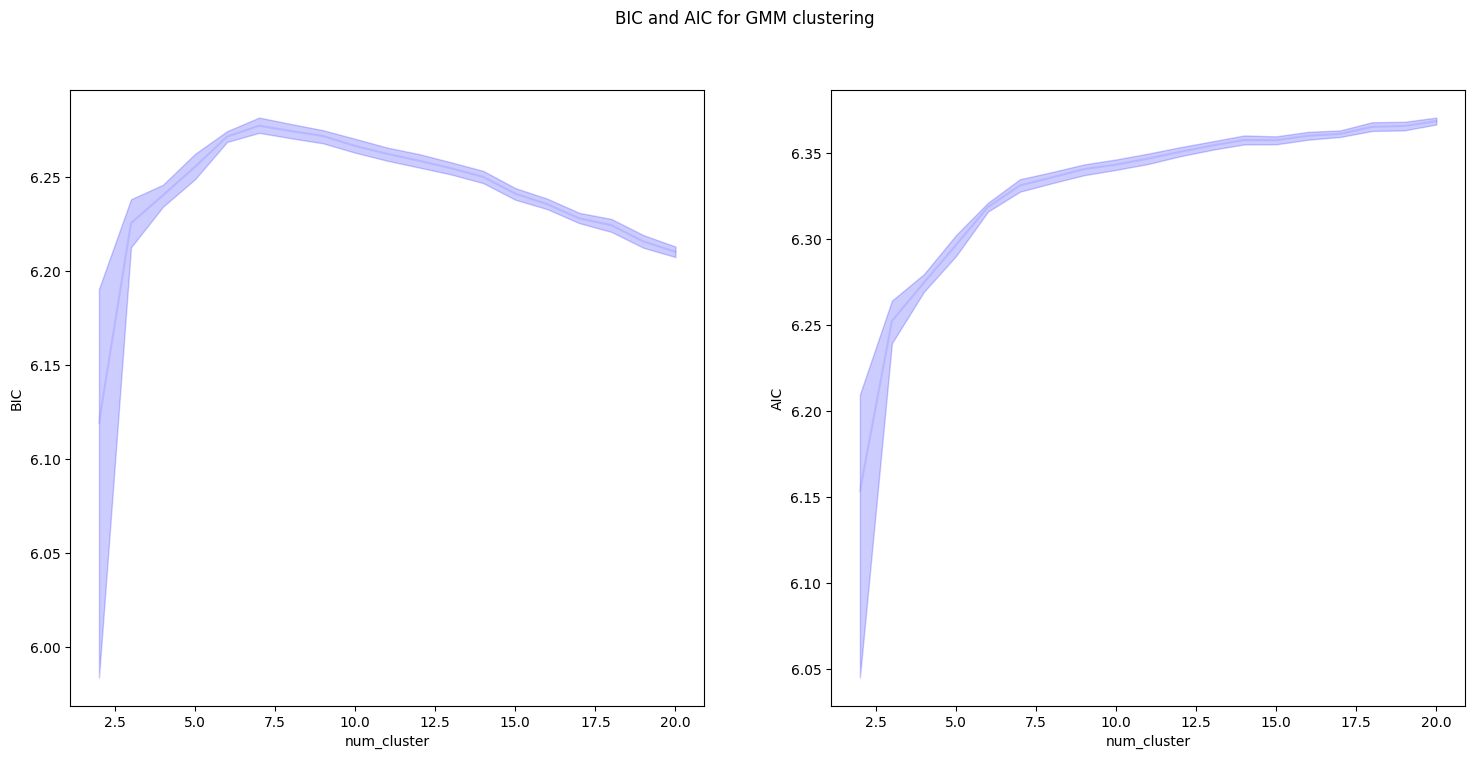

In [501]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.lineplot(data=res_df, x='num_cluster', y='BIC', alpha=0.1, c='b',  ax=ax[0])
sns.lineplot(data=res_df, x='num_cluster', y='AIC', alpha=0.1, c='b',  ax=ax[1])
fig.suptitle("-log(BIC) and -log(AIC) for GMM clustering")